In [1]:
import threadpoolctl
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from imblearn.over_sampling import SMOTE
from sklearn.utils import resample

import warnings
warnings.filterwarnings('ignore')

In [2]:
dataframe = pd.read_csv("academic_stress_levels.csv")

In [3]:
#Trabalhar com espaços causa muito problema então foi tomada a decisão de renomear as colunas.

df_format = pd.DataFrame({'timestamp': dataframe['Timestamp'],
                       'academic_stage': dataframe['Your Academic Stage'],
                       'peer_pressure': dataframe['Peer pressure'],
                       'academic_pressure_home': dataframe['Academic pressure from your home'],
                       'study_environment': dataframe['Study Environment'],
                       'coping_strategy': dataframe['What coping strategy you use as a student?'],
                       'bad_habits': dataframe['Do you have any bad habits like smoking, drinking on a daily basis?'],
                       'academic_competition_level': dataframe['What would you rate the academic  competition in your student life'],
                       'academic_stress_index': dataframe['Rate your academic stress index ']})

In [4]:
#A coluna timestamp foi descartada pois não teria utilidade alguma daqui em diante.

df_format = df_format.drop('timestamp', axis =1)

In [5]:
#Construir um dicionário é sempre uma boa prática, principalmente em projetos mais longos ou com mais variáveis. Ajuda a se orientar e evita confusão.

df_dict = {
    "academic_stage": "Grau de educação do estudante.",
    "peer_pressure": "Pressão social",
    "academic_pressure_home": "Expectativas e pressão acadêmica exercida na casa do estudante.",
    "study_environment":"Descrição do ambiente de estudo.",
    "coping_strategy":"Estratégias para lidar com o stress e demais desafios.",
    "bad_habits":"Hábitos negativos que o estudante costuma recorrer devido ao stress.",
    "academic_competition_level":"Intensidade de competição entre os pares.",
    "academic_stress_index":"Intensidade de stress por motivos acadêmicos."
}

In [6]:
#Neste bloco são definidas as variáveis categóricas que passarão pelo processo de encoding. 
#Devido ao tamanho do Dataset foi decidido utilizar a função "get_dummies" do panda ao invés de outras opções, como importar algum encoder do SKLearn.

categoricas = ['academic_stage', 'study_environment', 'coping_strategy', 'bad_habits']

df_enc = df_format.copy()
for c in categoricas:
    df_enc[c] = df_enc[c].astype('string')

df_enc = pd.get_dummies(df_enc, columns=categoricas, drop_first=True)
df_enc.head()

,peer_pressure,academic_pressure_home,academic_competition_level,academic_stress_index,academic_stage_post-graduate,academic_stage_undergraduate,study_environment_Peaceful,study_environment_disrupted,coping_strategy_Emotional breakdown (crying a lot),"coping_strategy_Social support (friends, family)",bad_habits_Yes,bad_habits_prefer not to say
0,4,5,3,5,False,True,False,False,False,False,False,False
1,3,4,3,3,False,True,True,False,False,False,False,False
2,1,1,2,4,False,True,True,False,False,True,False,False
3,3,2,4,3,False,True,True,False,False,False,False,False
4,3,3,4,5,False,True,True,False,False,False,False,False


In [7]:
#O objetivo era manter o dataset na mesma ordem inicial, então a coluna "acadmic_stress_index" foi movida para a última posição.

alvo = df_enc.pop('academic_stress_index') 
df_enc['academic_stress_index'] = alvo      

In [8]:
df_enc.describe()

,peer_pressure,academic_pressure_home,academic_competition_level,academic_stress_index
count,140.000000,140.000000,140.000000,140.000000
mean,3.071429,3.178571,3.492857,3.721429
std,1.083844,1.276618,1.028349,1.032339
min,1.000000,1.000000,1.000000,1.000000
25%,2.000000,2.000000,3.000000,3.000000
50%,3.000000,3.000000,4.000000,4.000000
75%,4.000000,4.000000,4.000000,4.000000
max,5.000000,5.000000,5.000000,5.000000


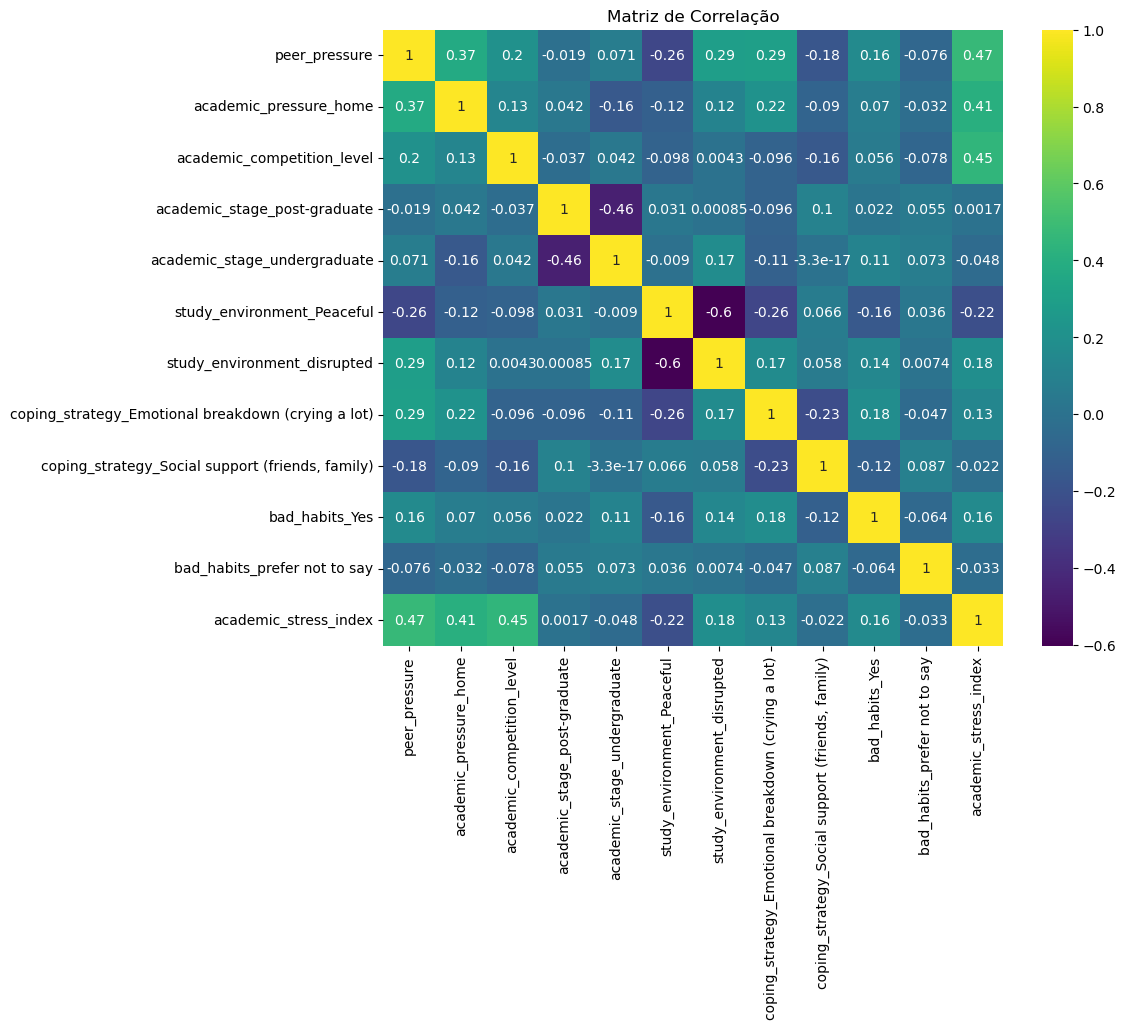

In [9]:
#Calculando a matriz de correlação
correlation_matrix = df_enc.corr()

plt.figure(figsize = (10,8))
sns.heatmap(correlation_matrix, annot = True, cmap = 'viridis')
plt.title('Matriz de Correlação')
plt.show()

In [10]:
cluster = df_enc.drop(columns=['academic_stress_index'])
scaler = StandardScaler()
cluster_scaled = scaler.fit_transform(cluster)

In [11]:
#Lista para armazenar o SSE
sse = []

k_range = range(2, 9)

for k in k_range:
    kmeans = KMeans(n_clusters = k, random_state=23)
    kmeans.fit(cluster_scaled)
    sse.append(kmeans.inertia_)

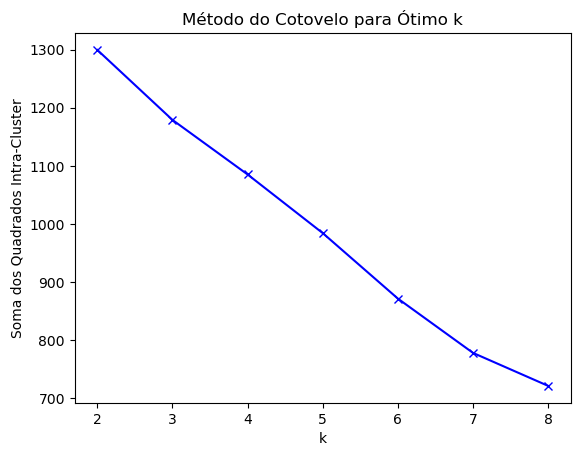

In [12]:
plt.plot(k_range, sse, 'bx-')
plt.xlabel('k')
plt.ylabel('Soma dos Quadrados Intra-Cluster')
plt.title('Método do Cotovelo para Ótimo k')
plt.show()

Para encontrar o valor ótimo de K usando o método do cotovelo é preciso encontrar o ponto onde a curva forma um "cotovelo". É evidente que o gráfico exibido acima é linear, logo, o método do cotovelo não foi capaz de ajudar a descobrir muita coisa. Diante desse resultado inconclusivo deve-se pensar em utilizar outra estratégia, como o "Silhouette Score".


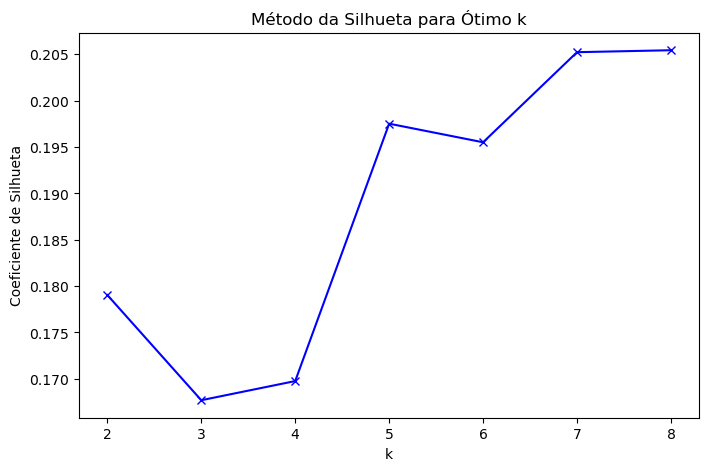

In [13]:
k_range = range(2, 9)

#Lista para o Silhouette score
sil_score = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=23)
    kmeans.fit(cluster_scaled)
    sil_score.append(silhouette_score(cluster_scaled, kmeans.labels_))

plt.figure(figsize=(8, 5))
plt.plot(k_range, sil_score, 'bx-')
plt.xlabel('k')
plt.ylabel('Coeficiente de Silhueta')
plt.title('Método da Silhueta para Ótimo k')
plt.show()



O Método da Silhueta varia de -1 a 1 onde um ponto mais próximo de 1 representa clusters bem separados, pontos próximos de zero representam clusters sobrepostos e valores negativos indicariam erros nos clusters. O gráfico não exibe métricas satisfatórias, mas sim o oposto: o maior valor ainda está muito abaixo do limite aceitável.     

Se nos projetos anteriores o dataset já demonstrava ser desafiador, aqui essa característica é ressaltada exponencialmente. Realisticamente falando sequer haveria motivos para continuar o processo, o ideal seria rever o dataset antes de dar continuidade. Entretanto, indiposto a descartar o projeto, tomei a decisão de continuar com três clusters. Sim, o pior valor, porém em números absolutos a diferença é de apenas 0.038, que se traduz em uma performance 22.5% inferior.

Contudo a visão do projeto, já na sua terceira extensão, era separar os estudantes em perfis para auxiliar o sistema integrado de triagem. Especificamente três perfis foram imaginados:     
Cluster 1: "Estressados por pressão familiar + ambiente disruptivo"    
Cluster 2: "Estressados por competição acadêmica + isolamento social"     
Cluster 3: "Estressados por múltiplos fatores + estratégias inadequadas"     

Uma vez que o desafio de conseguir um desempenho adequado parecia precisar de um milagre para ser superado, tomei a decisão de seguir com a visão inicial e documentar os resultados.

In [14]:
kmeans = KMeans(n_clusters=3, random_state=23)
cluster['cluster'] = kmeans.fit_predict(cluster_scaled)

In [15]:
cluster.head()

,peer_pressure,academic_pressure_home,academic_competition_level,academic_stage_post-graduate,academic_stage_undergraduate,study_environment_Peaceful,study_environment_disrupted,coping_strategy_Emotional breakdown (crying a lot),"coping_strategy_Social support (friends, family)",bad_habits_Yes,bad_habits_prefer not to say,cluster
0,4,5,3,False,True,False,False,False,False,False,False,1
1,3,4,3,False,True,True,False,False,False,False,False,2
2,1,1,2,False,True,True,False,False,True,False,False,0
3,3,2,4,False,True,True,False,False,False,False,False,2
4,3,3,4,False,True,True,False,False,False,False,False,2


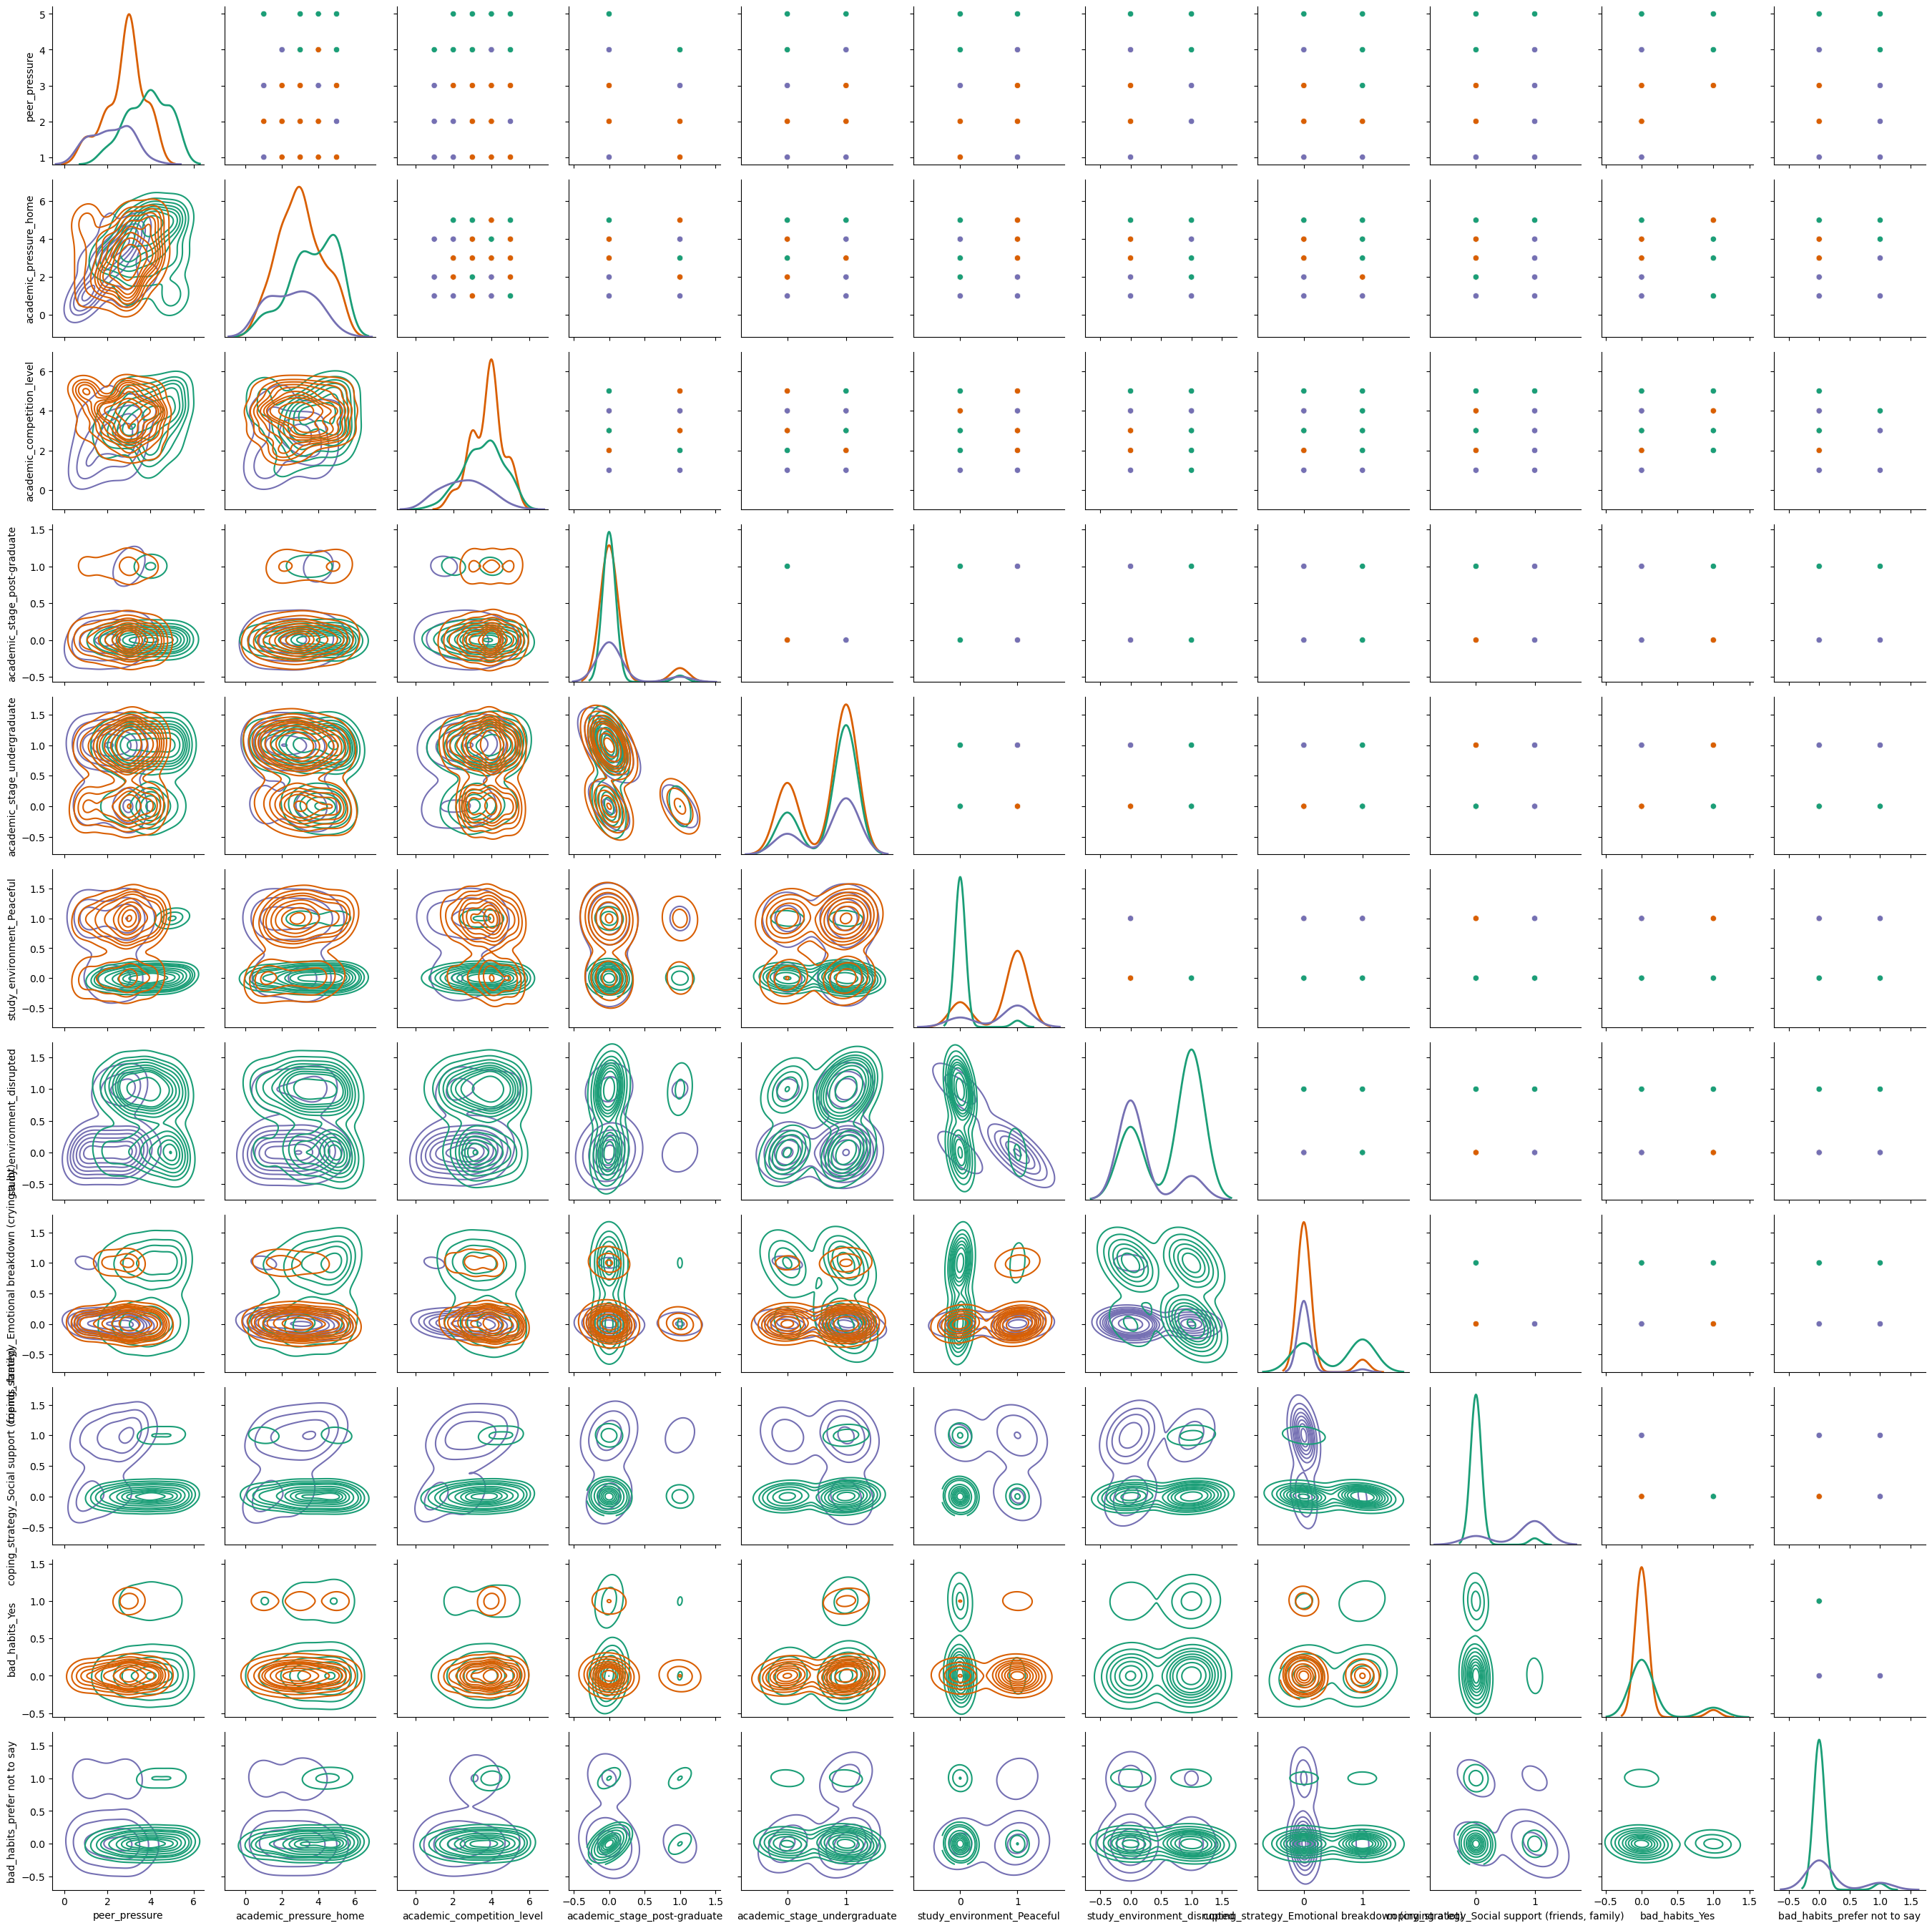

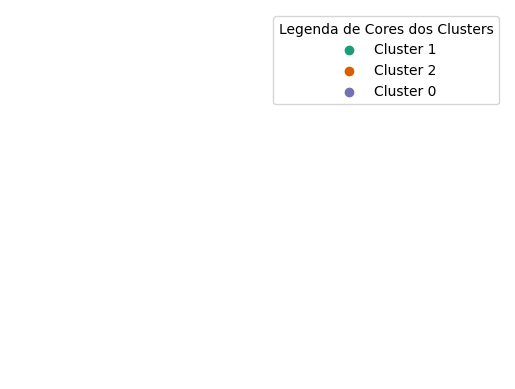

In [16]:
palette = sns.color_palette('Dark2', n_colors = len(cluster['cluster'].unique()))
color_map = dict(zip(cluster['cluster'].unique(), palette))

#O objetivo aqui é criar uma grade de gráficos mostrando a divisão dos clusters e em seguida uma legenda para o mapa de cores. 
g = sns.PairGrid(cluster, hue = 'cluster', palette = color_map, diag_sharey = False)
g.map_upper(sns.scatterplot)
g.map_lower(sns.kdeplot)
g.map_diag(sns.kdeplot, lw = 2)
plt.show()

for cluster, color in color_map.items():
    plt.scatter([], [], c = [color], label = f'Cluster {cluster}')
plt.legend(title = 'Legenda de Cores dos Clusters')
plt.axis('off')
plt.show()

Analisando a grade é evidente a baixa qualidade dos clusters. As linhas estão extremamente sobrepostas e, na maioria dos casos, é praticamente impossível dissociar um grupo do outro. Este resultado já era esperado, porém, mais uma vez, a questão do volume de dados vem à tona e a investigação se inicia novamente.     

Utilizando a mesma técnica aplicada no projeto anterior para aumentar os dados com SMOTE e melhorar a performance do modelo regressor, foram adicionados registros sintéticos para compor um volume de dados com 2.000 registros. Com o dataset maior o objetivo é investigar se há aumento no Silhouette Score. 

In [17]:
#EXPERIMENTO:

cluster_data = df_enc.drop(columns=['academic_stress_index'])
cluster_numpy = cluster_data.values.astype(int)

y_temp = df_enc['academic_stress_index'].values.astype(int)

smote = SMOTE(random_state=23, k_neighbors=3)
X_temp, y_temp = smote.fit_resample(cluster_numpy, y_temp)

X_synth, _ = resample(X_temp, y_temp, n_samples=2000, random_state=23)

scaler_synth = StandardScaler()
X_synth_scaled = scaler_synth.fit_transform(X_synth)

kmeans_synth = KMeans(n_clusters=3, random_state=23)
clusters_synth = kmeans_synth.fit_predict(X_synth_scaled)

sil_synth = silhouette_score(X_synth_scaled, clusters_synth)

print("COMPARAÇÃO ENTRE DADOS REAIS E SINTÉTICOS:")
print(f"Dados REAIS (140):     Silhouette = 0.168")
print(f"Dados SINTÉTICOS (2k): Silhouette = {sil_synth:.3f}")
print(f"Diferença:             {sil_synth - 0.168:+.3f}")

COMPARAÇÃO ENTRE DADOS REAIS E SINTÉTICOS:
Dados REAIS (140):     Silhouette = 0.168
Dados SINTÉTICOS (2k): Silhouette = 0.274
Diferença:             +0.106


O resultado não foi diferente, a melhor performance ainda é muito abaixo do aceitável. É possível concluir que o problema não era o volume de dados, as variáveis tem correlações muito fracas e não formam grupos naturais. Padrões de estresse são repletos de nuances individuais complicadas e isso torna um dataset com essas limitações intrinsecamente difícil de clusterizar.     


Essa terceira parte do projeto era bem ambiciosa, principalmente observando as dificuldades encontradas ao criar os modelos de classificação e regressão. Entretanto, após rejeitar a hipótese da "quantidade pequena de dados" é possível encerrar o projeto sem nenhuma dúvida sobre formas de melhorar a performance. 